In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

: 

In [4]:
df = pd.read_csv('D:/AIL_code/project/dataset/heart.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## Tổng quan về bộ dữ liệu

| Tên              | Ý nghĩa                                                  | Tác dụng                                                                 |
|------------------|-----------------------------------------------------------|-------------------------------------------------------------------------|
| Age              | Tuổi của bệnh nhân                                        | Đánh giá nguy cơ tim mạch tăng theo độ tuổi                            |
| Sex              | Giới tính (Nam/Nữ)                                        | Xác định ảnh hưởng của giới tính đến bệnh tim                          |
| ChestPainType    | Loại đau ngực (typical, atypical, non-anginal, asymptomatic) | Phân biệt các dạng đau ngực giúp chẩn đoán                            |
| RestingBP        | Huyết áp lúc nghỉ (mm Hg)                                 | Phát hiện huyết áp cao, yếu tố nguy cơ tim mạch                        |
| Cholesterol      | Mức cholesterol huyết thanh (mg/dl)                       | Xác định tình trạng mỡ máu, ảnh hưởng đến bệnh tim                     |
| FastingBS        | Đường huyết lúc đói > 120 mg/dl (1: có, 0: không)         | Phát hiện tiền tiểu đường/tiểu đường – nguy cơ tim mạch                |
| RestingECG       | Kết quả điện tâm đồ khi nghỉ                              | Phát hiện bất thường điện tim ban đầu                                  |
| MaxHR            | Nhịp tim tối đa khi gắng sức                              | Đánh giá khả năng chịu đựng tim và chức năng tim                       |
| ExerciseAngina   | Có đau thắt ngực khi gắng sức không (Y/N)                | Đánh giá mức độ ảnh hưởng của tim khi hoạt động                        |
| Oldpeak          | Mức độ trũng ST so với nghỉ (mm)                 | Chỉ số điện tim phản ánh thiếu máu cơ tim                              |
| ST_Slope         | Độ dốc của đoạn ST sau khi vận động                      | Giúp chẩn đoán thiếu máu cơ tim (up, flat, down)         |
| HeartDisease     | Kết quả chẩn đoán bệnh tim (1: có, 0: không)             | Mục tiêu để mô hình học và dự đoán                                |


## RestingBP and Cholesterol can never be 0 and hence are replaced by the mean values of their columns

In [5]:

print(f"Total missing values:- \n{df.isnull().sum()}\n")
print(f"Total duplicates: {df.duplicated().sum()}")

zero_cols = ['RestingBP', 'Cholesterol']
df[zero_cols] = df[zero_cols].replace(0, np.nan)
df['RestingBP'] = df['RestingBP'].fillna(df['RestingBP'].mean()) 
df['Cholesterol'] = df['Cholesterol'].fillna(df['Cholesterol'].mean()) 
df.head()

Total missing values:- 
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Total duplicates: 0


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0


HeartDisease
1    508
0    410
Name: count, dtype: int64


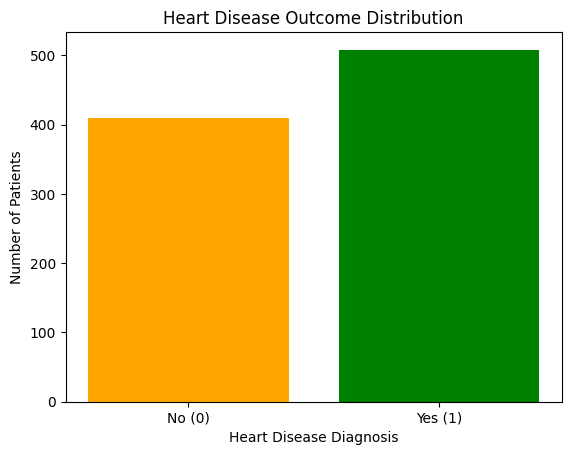

In [6]:

print(df['HeartDisease'].value_counts())

outcomes = ['No (0)', 'Yes (1)']
numbers = [df['HeartDisease'].value_counts().get(0, 0), df['HeartDisease'].value_counts().get(1, 0)]

plt.bar(outcomes, numbers, color=['orange', 'green'])
plt.xlabel('Heart Disease Diagnosis')
plt.ylabel('Number of Patients')
plt.title('Heart Disease Outcome Distribution')
plt.show()

Từ biểu đồ, ta có thể rút ra những kết luận sau:

- Tập dữ liệu này chứa thông tin của tổng cộng 918 bệnh nhân (410 + 508).
- Số lượng bệnh nhân mắc bệnh tim (508 người) nhiều hơn số lượng bệnh nhân không mắc bệnh tim (410 người).
- Tập dữ liệu này có sự mất cân bằng nhẹ giữa hai nhóm, với nhóm "Có bệnh tim" chiếm đa số. Điều này là một thông tin quan trọng cần lưu ý nếu sử dụng tập dữ liệu này để xây dựng các mô hình học máy, vì nó có thể ảnh hưởng đến hiệu suất của mô hình.

## Correlation matrix

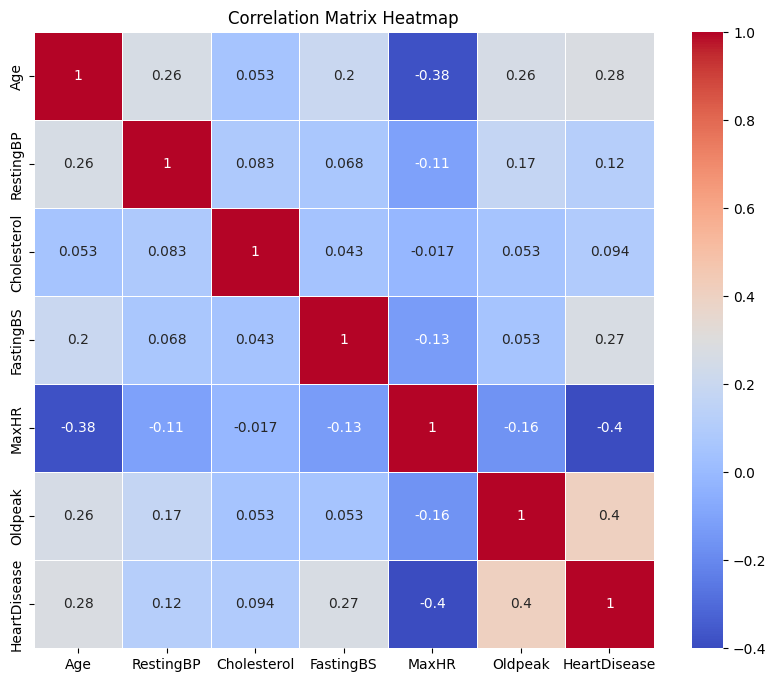

In [7]:
plt.figure(figsize=(10, 8))  
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Kết luận

**A. Các yếu tố có tương quan DƯƠNG mạnh nhất với Bệnh tim**

Đây là những yếu tố mà khi giá trị của chúng tăng lên, nguy cơ mắc bệnh tim cũng **tăng theo**.

- **`Oldpeak` (Hệ số: 0.4):**
    - **Ý nghĩa:** Đây là mối tương quan dương **mạnh nhất** với `HeartDisease` trong biểu đồ này. `Oldpeak` thường là chỉ số đo sự chênh lệch của đoạn ST trên điện tâm đồ khi gắng sức so với khi nghỉ ngơi.
    - **Kết luận:** Giá trị `Oldpeak` **càng cao** thì khả năng bệnh nhân được chẩn đoán mắc bệnh tim **càng cao**. Đây là một yếu tố dự báo **quan trọng**.
- **`Age` (Tuổi - Hệ số: 0.28):**
    - **Ý nghĩa:** Có mối tương quan dương ở **mức độ vừa phải**.
    - **Kết luận:** Tuổi tác **càng cao**, nguy cơ mắc bệnh tim **càng tăng**. 
- **`FastingBS` (Đường huyết lúc đói - Hệ số: 0.27):**
    - **Ý nghĩa:** Có mối tương quan dương.
    - **Kết luận:** Bệnh nhân có chỉ số đường huyết lúc đói **cao hơn** có xu hướng có nguy cơ mắc bệnh tim **cao hơn**.

**B. Yếu tố có tương quan ÂM mạnh nhất với Bệnh tim**

Đây là yếu tố mà khi giá trị của chúng giảm đi, nguy cơ mắc bệnh tim lại tăng lên.

- **`MaxHR` (Nhịp tim tối đa - Hệ số: -0.4):**
    - **Ý nghĩa:** Đây là mối tương quan **âm mạnh nhất**. `MaxHR` là nhịp tim tối đa mà một người có thể đạt được khi hoạt động gắng sức.
    - **Kết luận:** Bệnh nhân có khả năng đạt được nhịp tim tối đa **càng thấp** thì nguy cơ mắc bệnh tim **càng cao**. Nói cách khác, một trái tim khỏe mạnh có khả năng đập nhanh hơn khi gắng sức. Đây là một chỉ số dự báo bệnh tim **rất quan trọng**.

**C. Các yếu tố có tương quan YẾU với Bệnh tim**

- **`Cholesterol` (Hệ số: 0.094) và `RestingBP` (Hệ số: 0.12):**
    - **Ý nghĩa:** Các hệ số này **rất gần 0**.
    - **Kết luận:** Trong tập dữ liệu này, chỉ riêng chỉ số `Cholesterol` hoặc `RestingBP` **không phải** là yếu tố dự báo mạnh mẽ cho bệnh tim. Mối quan hệ của chúng có thể phức tạp hơn và cần được xem xét cùng các yếu tố khác.

### Tổng kết các kết luận chính

Dựa trên biểu đồ heatmap này, các yếu tố dự báo quan trọng nhất cho bệnh tim (`HeartDisease`) trong tập dữ liệu này là:

- **Các yếu tố nguy cơ** (khi tăng làm tăng khả năng mắc bệnh): `Oldpeak` (**mạnh nhất**), `Age`, và `FastingBS`.
- **Yếu tố bảo vệ** (khi tăng làm giảm khả năng mắc bệnh): `MaxHR` (Nhịp tim tối đa đạt được càng cao thì càng tốt).
- Các yếu tô như `Cholesterol` và `RestingBP` có vẻ **ít có ảnh hưởng trực tiếp** khi xét một cách độc lập.

## Histogram and pairplot for all the numeric columns

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'RestingBP'}>,
        <Axes: title={'center': 'Cholesterol'}>],
       [<Axes: title={'center': 'FastingBS'}>,
        <Axes: title={'center': 'MaxHR'}>,
        <Axes: title={'center': 'Oldpeak'}>],
       [<Axes: title={'center': 'HeartDisease'}>, <Axes: >, <Axes: >]],
      dtype=object)

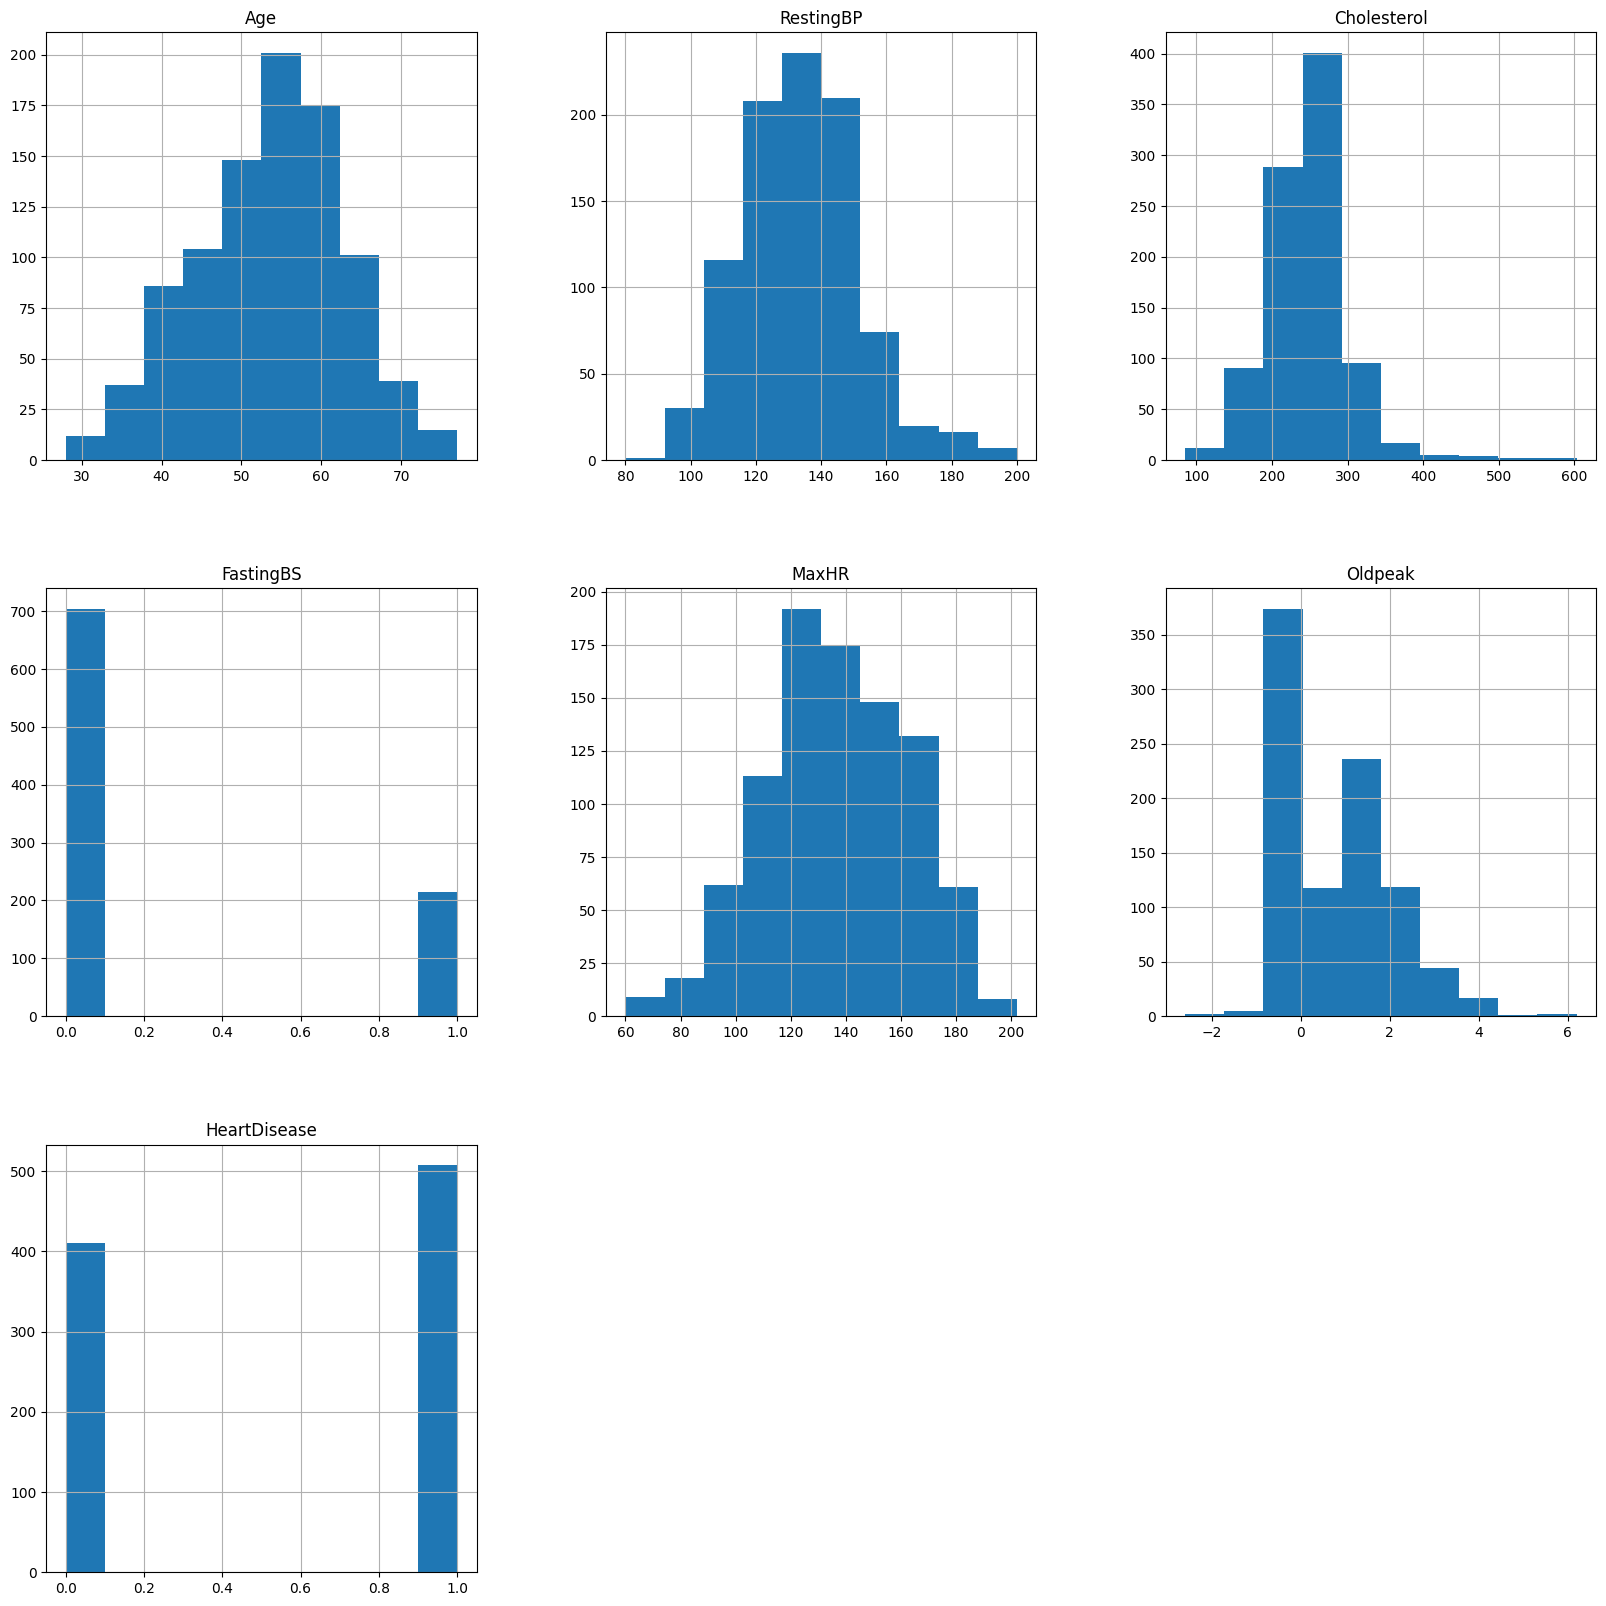

In [8]:
df.hist(figsize=(20,20))

### Phân tích và Ý nghĩa của các Biểu đồ Histogram

Các biểu đồ histogram cho thấy sự **phân phối (distribution)** của từng thuộc tính trong tập dữ liệu, giúp ta hiểu rõ hơn về đặc điểm của chúng.

- **`Age` (Tuổi):**
    - **Phân phối:** Biểu đồ có dạng gần giống **phân phối chuẩn (hình chuông)**, khá đối xứng.
    - **Ý nghĩa:** Đa số bệnh nhân trong tập dữ liệu này tập trung ở độ tuổi trung niên, khoảng từ **47 đến 63 tuổi**. Đỉnh của biểu đồ nằm ở khoảng 55-60 tuổi.

- **`RestingBP` (Huyết áp khi nghỉ):**
    - **Phân phối:** Có dạng gần giống **phân phối chuẩn**, với đỉnh nằm ở khoảng **120-140 mmHg**.
    - **Ý nghĩa:** Phần lớn bệnh nhân có huyết áp lúc nghỉ ở mức **bình thường đến hơi cao**.

- **`Cholesterol`:**
    - **Phân phối:** Phân phối **bị lệch phải (right-skewed)**.
    - **Ý nghĩa:** Hầu hết bệnh nhân có chỉ số cholesterol từ **180 đến 300 mg/dl**. Phân phối lệch phải cho thấy có nhiều bệnh nhân có chỉ số cholesterol ở mức thấp và trung bình, với một số ít bệnh nhân có chỉ số rất cao kéo dài về phía bên phải. Thanh cao nhất ở dải giá trị thấp nhất cho thấy một lượng lớn bệnh nhân có mức cholesterol trong khoảng này.

- **`FastingBS` (Đường huyết lúc đói):**
    - **Phân phối:** Đây là một **biến phân loại (categorical variable)** được mã hóa thành số, chỉ có hai giá trị là `0` và `1`.
    - **Ý nghĩa:** `0` có thể là đường huyết bình thường và `1` là đường huyết cao. Ta thấy rằng **số lượng người có đường huyết bình thường (cột 0) chiếm áp đảo**.

- **`MaxHR` (Nhịp tim tối đa):**
    - **Phân phối:** Có dạng gần giống hình chuông nhưng **hơi lệch trái (left-skewed)**. Đỉnh của phân phối nằm ở khoảng **130-160 nhịp/phút**.
    - **Ý nghĩa:** Đa số bệnh nhân đạt được nhịp tim tối đa trong khoảng này. Việc phân phối hơi lệch trái cho thấy có một số trường hợp có nhịp tim tối đa thấp hơn mức trung bình.

- **`Oldpeak`:**
    - **Phân phối:** Biểu đồ **lệch phải rất mạnh**.
    - **Ý nghĩa:** Phần lớn các giá trị `Oldpeak` tập trung ở gần **0**, đây là một dấu hiệu bình thường. Chỉ một số ít bệnh nhân có giá trị `Oldpeak` cao.

- **`HeartDisease` (Bệnh tim):**
    - **Phân phối:** Đây là **biến nhị phân (binary variable)**, là biến mục tiêu của chúng ta.
    - **Ý nghĩa:** Biểu đồ cho thấy số lượng bệnh nhân ở hai nhóm `0` (Không bệnh) và `1` (Có bệnh). Nhóm `1` có số lượng **cao hơn một chút** so với nhóm `0`, xác nhận lại sự mất cân bằng nhẹ của dữ liệu.

### Tổng kết các kết luận chính từ Histogram

- Các biến như `Age`, `RestingBP`, và `MaxHR` có phân phối gần giống **phân phối chuẩn**.
- Các biến `Oldpeak` và `Cholesterol` **bị lệch**, cho thấy dữ liệu không đối xứng.
- Các biến `FastingBS` và `HeartDisease` là các **biến phân loại** được mã hóa bằng số `0` và `1`, không phải biến số liên tục.

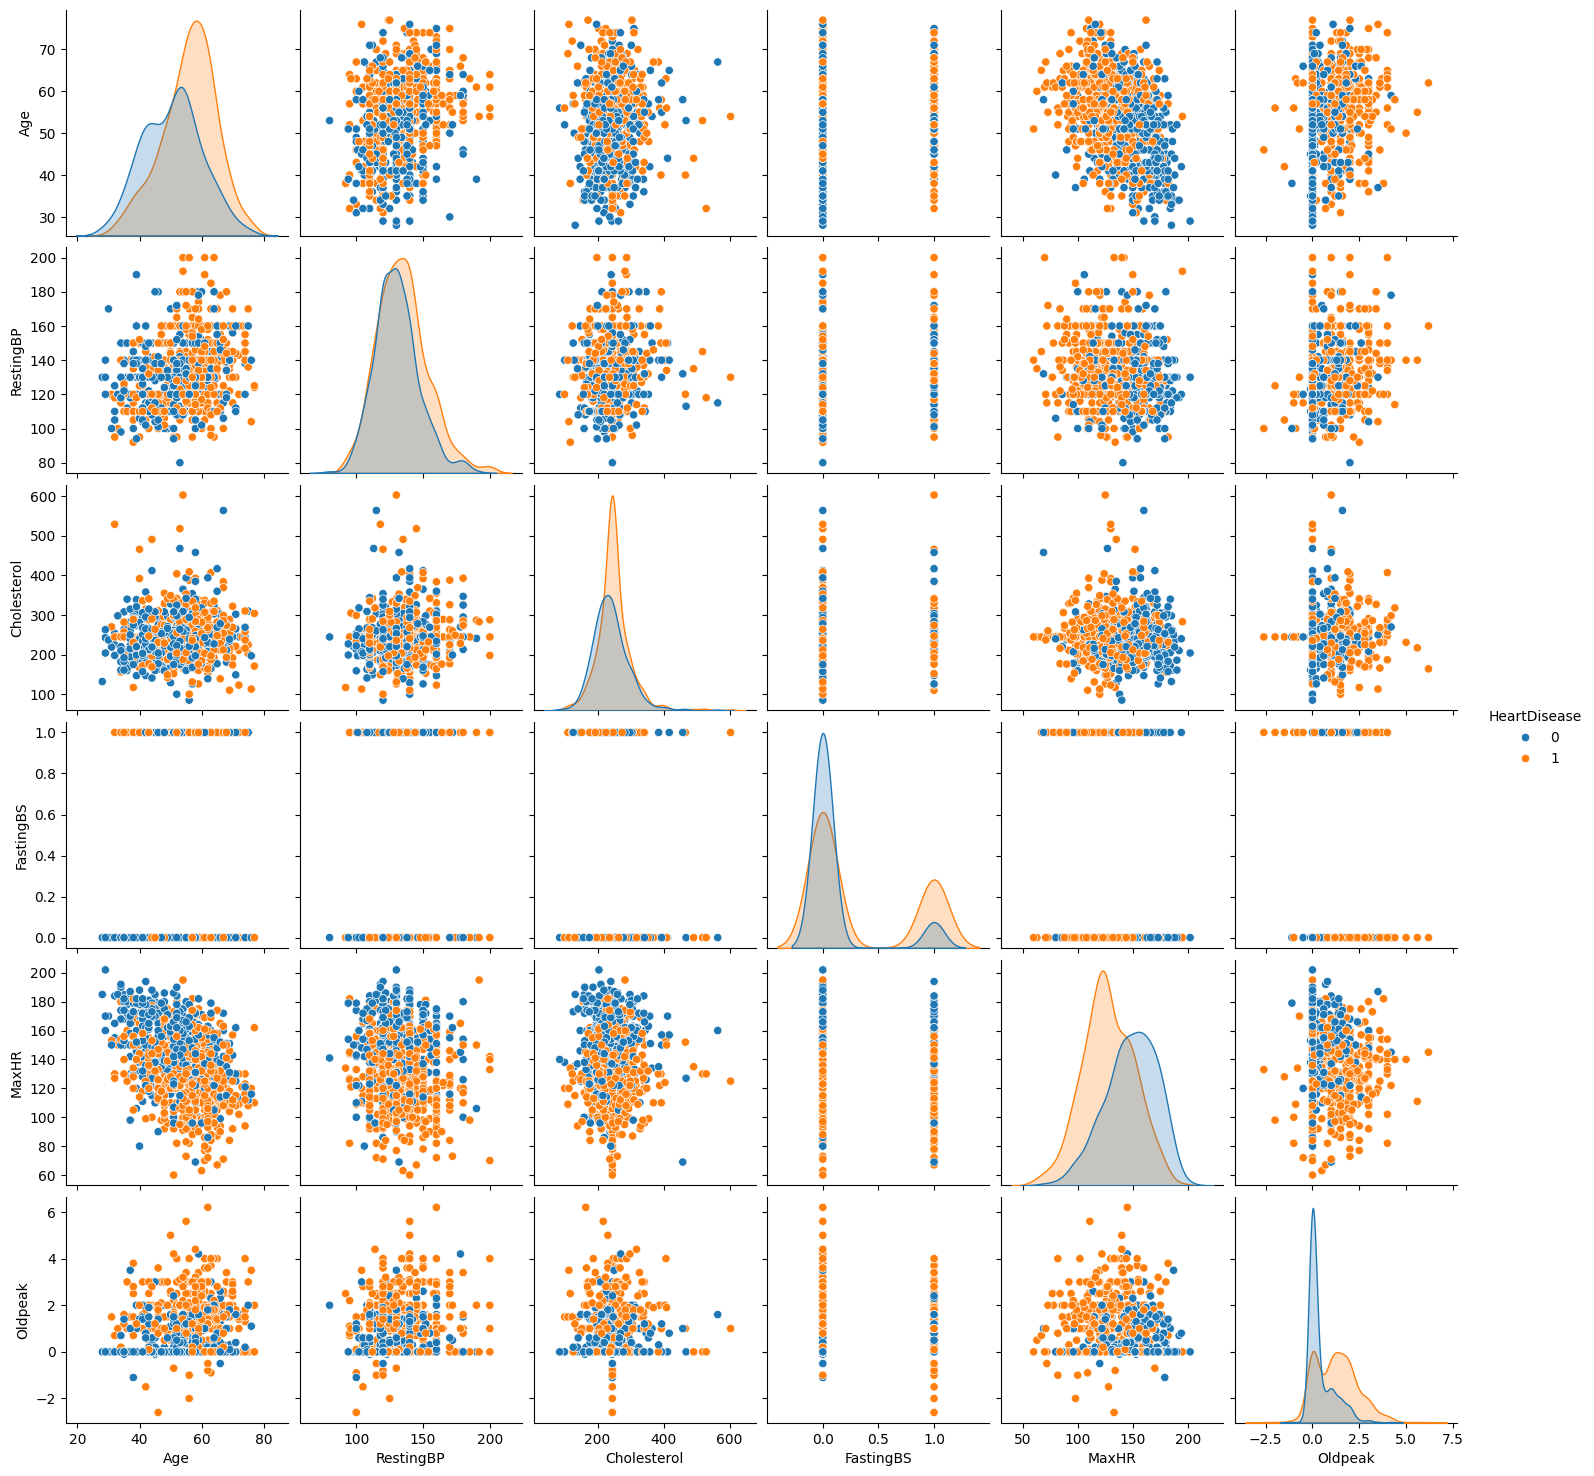

In [9]:
sns.pairplot(df, hue='HeartDisease') 

### Phân tích và Ý nghĩa của Biểu đồ Pairplot

Cách đọc biểu đồ này như sau:
- **Các ô trên đường chéo chính (từ trên trái xuống dưới phải):** Là biểu đồ **phân phối mật độ (KDE Plot)** của từng biến, được tô màu theo biến mục tiêu `HeartDisease`. Chúng cho thấy sự phân bố của từng thuộc tính cho nhóm "Có bệnh tim" (màu cam) và "Không có bệnh tim" (màu xanh).
- **Các ô còn lại (ngoài đường chéo):** Là các **biểu đồ phân tán (Scatter Plot)**, thể hiện mối quan hệ giữa hai biến khác nhau. Mỗi điểm dữ liệu được tô màu theo `HeartDisease`.

Mục tiêu chính khi phân tích biểu đồ này là tìm ra những thuộc tính hoặc cặp thuộc tính nào có khả năng **phân tách** hai nhóm "Có bệnh" và "Không có bệnh" một cách rõ ràng nhất.

### A. Phân tích trên đường chéo (Biểu đồ phân phối KDE)

Đây là nơi ta đánh giá khả năng dự báo của **từng thuộc tính riêng lẻ**. Sự tách biệt càng rõ ràng giữa hai đường cong màu cam và xanh thì thuộc tính đó càng tốt.

- **`Oldpeak`:**
    - **Phân phối:** Hai đường cong (cam và xanh) **tách biệt rất rõ ràng**. Nhóm "Không bệnh" (`0` - xanh) có đỉnh phân bố ở giá trị 0, trong khi nhóm "Có bệnh" (`1` - cam) có đỉnh phân bố ở giá trị cao hơn.
    - **Ý nghĩa:** Đây là dấu hiệu của một thuộc tính dự báo **rất tốt**.

- **`MaxHR` (Nhịp tim tối đa):**
    - **Phân phối:** Cũng có sự tách biệt tốt. Đỉnh của nhóm "Không bệnh" (xanh) nằm ở phía nhịp tim cao hơn so với đỉnh của nhóm "Có bệnh" (cam).
    - **Ý nghĩa:** `MaxHR` là một thuộc tính dự báo **tốt**. Nhịp tim tối đa thấp hơn có liên quan đến nguy cơ mắc bệnh tim cao hơn.

- **`Age` (Tuổi):**
    - **Phân phối:** Có sự tách biệt tương đối. Đỉnh của nhóm màu cam (Có bệnh) hơi lệch về phía tuổi cao hơn so với nhóm màu xanh.
    - **Ý nghĩa:** `Age` là một thuộc tính dự báo ở **mức độ vừa phải**.

- **`RestingBP` (Huyết áp khi nghỉ) & `Cholesterol`:**
    - **Phân phối:** Hai đường cong gần như **chồng lên nhau hoàn toàn**.
    - **Ý nghĩa:** Rất khó để phân biệt hai nhóm chỉ dựa vào hai thuộc tính này. Đây là những thuộc tính dự báo **yếu** khi xét riêng lẻ.

### B. Phân tích ngoài đường chéo (Biểu đồ phân tán Scatter Plot)

Đây là nơi ta đánh giá khả năng dự báo khi **kết hợp hai thuộc tính**. Ta tìm kiếm những ô mà các điểm màu cam và xanh tạo thành các cụm riêng biệt.

- **Cặp mạnh nhất (`MaxHR` và `Oldpeak`):**
    - **Phân tích:** Nhìn vào ô giao giữa hàng `Oldpeak` và cột `MaxHR`, ta thấy một xu hướng rõ rệt: các điểm màu cam (`1`) có xu hướng tập trung ở khu vực có `MaxHR` thấp và `Oldpeak` cao. Ngược lại, các điểm màu xanh (`0`) tập trung ở khu vực `MaxHR` cao và `Oldpeak` thấp.
    - **Ý nghĩa:** Sự phân tách này cho thấy kết hợp hai biến này sẽ **rất hiệu quả** cho mô hình trong việc phân loại bệnh nhân.

- **Cặp khá tốt (`Age` và `MaxHR`):**
    - **Phân tích:** Ô giao giữa `Age` và `MaxHR` cho thấy các điểm màu cam (Có bệnh) có xu hướng tập trung ở nhóm tuổi cao hơn và `MaxHR` thấp hơn.
    - **Ý nghĩa:** Đây cũng là một sự kết hợp có giá trị, củng cố thêm những gì ta thấy ở biểu đồ phân phối.

- **Cặp yếu nhất (`RestingBP` và `Cholesterol`):**
    - **Phân tích:** Trong ô giao giữa hai biến này, các điểm màu cam và xanh **trộn lẫn vào nhau** không có quy luật rõ ràng.
    - **Ý nghĩa:** Việc kết hợp hai biến này không mang lại nhiều khả năng phân tách, cho thấy chúng không phải là một cặp biến hữu ích để dự báo.

### Tổng kết các kết luận chính từ Pairplot

- **Các thuộc tính dự báo đơn lẻ tốt nhất:** `Oldpeak` và `MaxHR` là hai thuộc tính có khả năng phân biệt tốt nhất giữa hai nhóm bệnh nhân.
- **Sức mạnh của việc kết hợp thuộc tính:** Việc kết hợp các thuộc tính, đặc biệt là `Oldpeak` và `MaxHR`, mang lại khả năng phân tách hai nhóm tốt hơn nhiều so với việc chỉ dùng một thuộc tính đơn lẻ.
- **Các thuộc tính ít thông tin nhất:** `RestingBP` và `Cholesterol` cho thấy sự chồng chéo lớn giữa hai nhóm và ít có giá trị dự báo, cả khi xét riêng lẻ lẫn khi kết hợp với nhau.
- **Định hướng cho mô hình hóa:** Biểu đồ này giúp khẳng định rằng các mô hình học máy nên tập trung vào các thuộc tính như `Oldpeak`, `MaxHR`, và `Age` để có được hiệu suất tốt nhất.

## Sex division for the remaining object columns

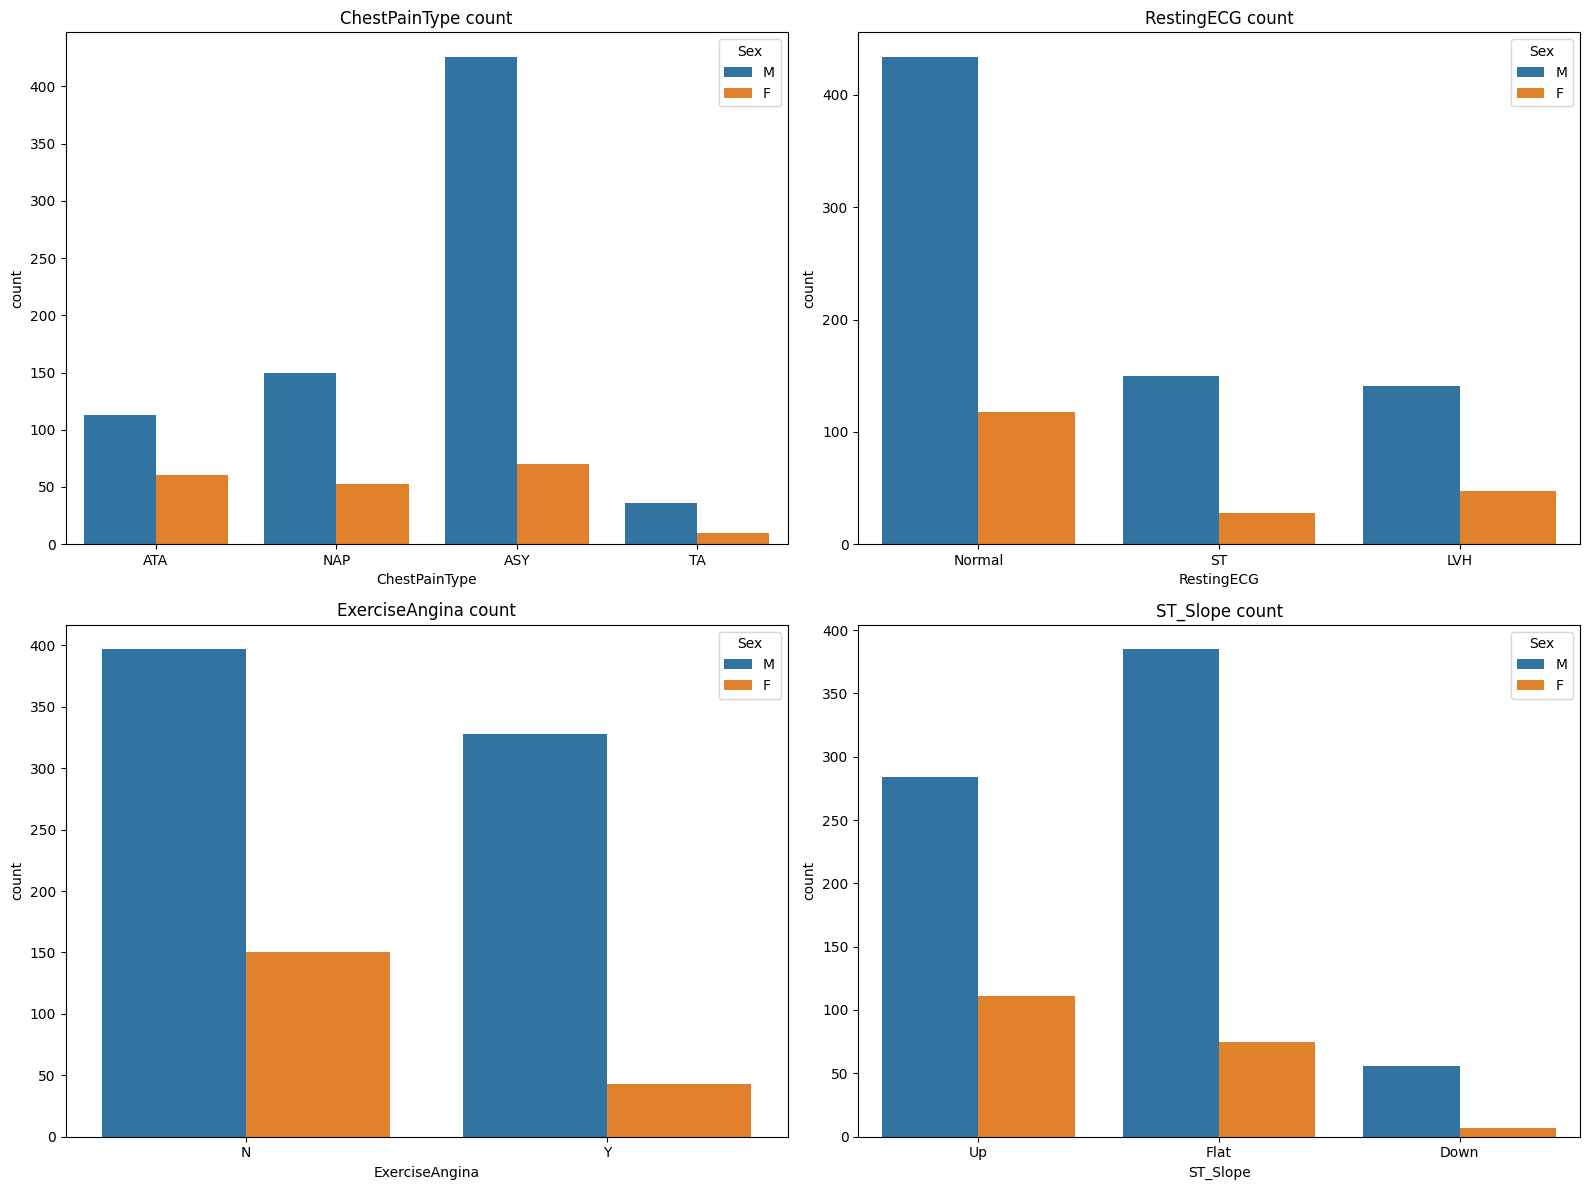

In [10]:
object_columns = ['ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'Sex']
n = 0
plt.figure(figsize=(16, 12))
for col in object_columns[:-1]: #we don't need the sex column here
    n+=1
    plt.subplot(2,2,n)
    sns.countplot(data=df,x=col,hue='Sex')
    plt.title(f"{col} count")

plt.tight_layout()
plt.show()

### Phân tích và Ý nghĩa của các Biểu đồ Count Plot

Các biểu đồ này được gọi là **Count Plot (Biểu đồ đếm)**. Chúng hiển thị số lượng (tần suất) của từng loại (category) trong một thuộc tính phân loại. Trong trường hợp này, mỗi biểu đồ còn được phân tách thêm theo **`Sex` (Giới tính)**, với màu xanh dương cho Nam (`M`) và màu cam cho Nữ (`F`).

Mục tiêu chính là hiểu về đặc điểm phân bố của các thuộc tính phân loại này và xem xét sự khác biệt về số lượng giữa hai giới tính.

### Phân tích chi tiết từng biểu đồ

- **`ChestPainType` (Loại đau ngực):**
    - **Phân tích:** Trong 4 loại đau ngực, loại **`ASY` (Asymptomatic - không có triệu chứng)** chiếm số lượng **áp đảo**, đặc biệt là ở nam giới. Số lượng nam giới (`M`) nhiều hơn nữ giới (`F`) trong tất cả các loại đau ngực.
    - **Ý nghĩa:** Đa số bệnh nhân trong tập dữ liệu này, nhất là nam giới, được ghi nhận với loại đau ngực không triệu chứng. Đây có thể là một đặc điểm quan trọng khi phân tích nguyên nhân gây bệnh tim.

- **`RestingECG` (Điện tâm đồ khi nghỉ):**
    - **Phân tích:** Kết quả điện tâm đồ **`Normal` (Bình thường)** là phổ biến nhất. Các loại `ST` (có bất thường sóng ST-T) và `LVH` (phì đại thất trái) có số lượng ít hơn. Tương tự, số lượng nam giới nhiều hơn nữ giới ở cả ba loại.
    - **Ý nghĩa:** Hầu hết bệnh nhân trong bộ dữ liệu có kết quả điện tâm đồ lúc nghỉ bình thường.

- **`ExerciseAngina` (Đau thắt ngực khi gắng sức):**
    - **Phân tích:** Biểu đồ này có hai loại: `N` (Không) và `Y` (Có). Số lượng bệnh nhân **không bị đau thắt ngực khi gắng sức (`N`) lớn hơn đáng kể** so với số người có triệu chứng này.
    - **Ý nghĩa:** Đau thắt ngực khi gắng sức không phải là một triệu chứng phổ biến trong nhóm đối tượng được khảo sát. Trong cả hai nhóm có và không có triệu chứng, nam giới đều chiếm đa số.

- **`ST_Slope` (Độ dốc đoạn ST):**
    - **Phân tích:** Trong ba loại độ dốc, **`Flat` (Đi ngang)** là loại phổ biến nhất, theo sau là **`Up` (Dốc lên)**. Loại `Down` (Dốc xuống) rất ít gặp.
    - **Ý nghĩa:** Đặc điểm độ dốc đoạn ST đi ngang là đặc điểm thường gặp nhất trong dữ liệu này. Đây là một chỉ số quan trọng trên điện tâm đồ gắng sức và thường có liên quan đến bệnh mạch vành.

### Tổng kết các kết luận chính

- **Sự mất cân bằng về Giới tính:** Điểm chung nổi bật nhất và quan trọng nhất trên cả bốn biểu đồ là **số lượng bệnh nhân nam (`M`) luôn nhiều hơn đáng kể so với bệnh nhân nữ (`F`)** trong gần như mọi hạng mục. Điều này cho thấy bộ dữ liệu có sự mất cân bằng lớn về giới tính, có thể ảnh hưởng đến kết quả của mô hình.
- **Đặc điểm của nhóm đa số:** "Bệnh nhân điển hình" trong bộ dữ liệu này có xu hướng là **nam giới**, với các đặc điểm: loại đau ngực **không triệu chứng (`ASY`)**, điện tâm đồ khi nghỉ **bình thường (`Normal`)**, **không bị đau thắt ngực khi gắng sức (`N`)**, và có độ dốc đoạn ST **đi ngang (`Flat`)**.
- **Định hướng cho mô hình hóa:** Do sự chênh lệch lớn về số lượng, biến `Sex` có khả năng là một thuộc tính dự báo quan trọng. Đồng thời, sự phổ biến của một số loại nhất định (như `ASY` hay `Flat`) cho thấy chúng là những đặc điểm cần được chú ý đặc biệt khi xây dựng mô hình.

## One-hot-encoding for the object dtype columns

In [11]:

df = pd.get_dummies(df, columns=object_columns, dtype='uint8') 
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex_F,Sex_M
0,40,140.0,289.0,0,172,0.0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
1,49,160.0,180.0,0,156,1.0,1,0,0,1,...,0,1,0,1,0,0,1,0,1,0
2,37,130.0,283.0,0,98,0.0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,1
3,48,138.0,214.0,0,108,1.5,1,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,54,150.0,195.0,0,122,0.0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1


# We'll try 3 models: XGBoost, Random Forest and Logistic Regression

## Creating the training and testing datasets

In [12]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. XGBoost Model

In [13]:
from xgboost import XGBClassifier
model1 = XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=300,
    objective='binary:logistic',
    eval_metric='logloss'
)

param_dist1 = {
    'max_depth' : [3,4,5,6,7,8,9],
    'learning_rate' : [0.01, 0.05, 0.1, 0.3],
    'n_estimators' : [100, 200, 500],
    'subsample' : [0.6, 0.7, 0.9, 1.0],
    'colsample_bytree' : [0.6, 0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5], # L1 regularization parameters
    'reg_alpha' : [0, 0.1, 1],
    }

random_search1 = RandomizedSearchCV(model1,
                    param_distributions=param_dist1,
                    scoring = 'f1',
                    n_iter = 100,
                    cv = 3,
                    verbose = 1,
                    n_jobs=-1
                    )

random_search1.fit(X_train, y_train)
print("Best parameters: ", random_search1.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters:  {'subsample': 1.0, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [14]:
best_model = random_search1.best_estimator_
y_pred1 = best_model.predict(X_test)

print(f"Best accuracy: {accuracy_score(y_test, y_pred1):.4f}")
print(f"Best f1 score: {f1_score(y_test, y_pred1):.4f}")
print(f"Best recall score: {recall_score(y_test, y_pred1):.4f}")
print(f"Best roc-auc score: {roc_auc_score(y_test, y_pred1):.4f}")
print(f"Classification report: \n{classification_report(y_test, y_pred1)}")

Best accuracy: 0.8659
Best f1 score: 0.8840
Best recall score: 0.8598
Best roc-auc score: 0.8674
Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       112
           1       0.91      0.86      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276



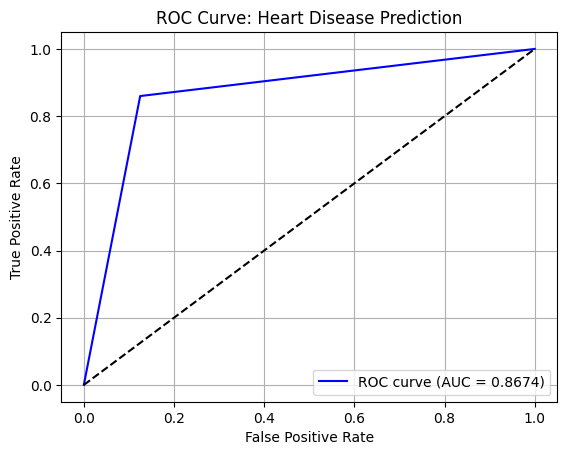

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred1):.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Heart Disease Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Phân tích Hiệu suất Mô hình XGBoost

### 1. ROC Curve và chỉ số AUC

- **`ROC Curve` (Đường cong ROC):**
    - **Ý nghĩa:** Đây là đường cong biểu diễn khả năng của mô hình trong việc **phân biệt** giữa hai lớp (có bệnh và không có bệnh). Nó được vẽ dựa trên **Tỷ lệ Dương tính Thật (True Positive Rate)** và **Tỷ lệ Dương tính Giả (False Positive Rate)** ở các ngưỡng phân loại khác nhau.
    - **Phân tích:**
        - Đường cong màu xanh của mô hình **nằm rất xa về phía góc trên bên trái** so với đường chéo màu đen (đường chéo thể hiện việc dự đoán ngẫu nhiên).
        - Điều này cho thấy mô hình của bạn hoạt động **tốt hơn rất nhiều** so với việc đoán ngẫu nhiên.

- **`AUC` (Area Under the Curve - Diện tích dưới đường cong):**
    - **Giá trị:** **0.8674**
    - **Kết luận:** Chỉ số AUC đo lường toàn bộ khả năng phân biệt của mô hình trên tất cả các ngưỡng.
        - `AUC = 0.5`: Mô hình không có khả năng phân biệt (như đoán mò).
        - `AUC = 1.0`: Mô hình phân biệt một cách hoàn hảo.
    - Với giá trị **AUC là 0.8674**, mô hình XGBoost của bạn có khả năng phân biệt **rất tốt** giữa bệnh nhân có bệnh tim và không có bệnh tim. Đây là một kết quả rất đáng khích lệ.

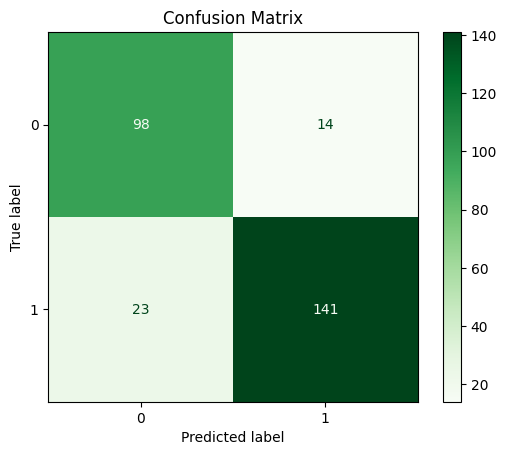

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()

### 2. Confusion Matrix

- **Giải thích các ô trong Ma trận:**
    - Ma trận này cho chúng ta cái nhìn chi tiết về các dự đoán đúng và sai của mô hình. Trong đó, `0` là "Không bệnh" và `1` là "Có bệnh".
    - **`True Negative (TN)`: 98**
        - **Ý nghĩa:** Mô hình đã dự đoán đúng **98** người là **không có bệnh tim**.
    - **`False Positive (FP)`: 14**
        - **Ý nghĩa:** Mô hình đã dự đoán **sai 14** người là có bệnh tim, trong khi thực tế họ không có (Sai lầm loại I).
    - **`False Negative (FN)`: 23**
        - **Ý nghĩa:** Mô hình đã dự đoán **sai 23** người là không có bệnh tim, trong khi thực tế họ có (Sai lầm loại II - Bỏ sót).
    - **`True Positive (TP)`: 141**
        - **Ý nghĩa:** Mô hình đã dự đoán đúng **141** người là **có bệnh tim**.

- **Đánh giá chi tiết hiệu suất:**
    - **Độ chính xác (Accuracy):** Tỷ lệ dự đoán đúng trên tổng số.
        - `(TP + TN) / Tổng = (141 + 98) / (98 + 14 + 23 + 141) = 239 / 276 ≈ 86.6%`. Đây là một độ chính xác cao.
    - **Độ nhạy (Recall/Sensitivity):** Khả năng "phát hiện" đúng những người thực sự có bệnh.
        - `TP / (TP + FN) = 141 / (141 + 23) ≈ 86.0%`. Mô hình tìm ra được **86%** trong tổng số những người thật sự có bệnh.
    - **Độ đặc hiệu (Specificity):** Khả năng xác định đúng những người không có bệnh.
        - `TN / (TN + FP) = 98 / (98 + 14) ≈ 87.5%`. Mô hình xác định đúng **87.5%** trong tổng số những người thật sự không có bệnh.
    - **Sự đánh đổi quan trọng:** Mô hình có số lượng **False Negative (23)** cao hơn **False Positive (14)**. Điều này có nghĩa là mô hình có xu hướng **bỏ sót bệnh nhân** nhiều hơn là chẩn đoán nhầm cho người khỏe mạnh. Trong ứng dụng y tế, đây là một điểm cần phải cân nhắc và cải thiện, vì bỏ sót bệnh thường nguy hiểm hơn.

### 2. Random Forest Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

model2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [18]:



print(f"Best accuracy: {accuracy_score(y_test, y_pred2):.4f}")
print(f"Best f1 score: {f1_score(y_test, y_pred2):.4f}")
print(f"Best recall score: {recall_score(y_test, y_pred2):.4f}")
print(f"Best roc-auc score: {roc_auc_score(y_test, y_pred2):.4f}")
print(f"Classification report: \n{classification_report(y_test, y_pred2)}")

Best accuracy: 0.8804
Best f1 score: 0.8985
Best recall score: 0.8902
Best roc-auc score: 0.8782
Classification report: 
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       112
           1       0.91      0.89      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



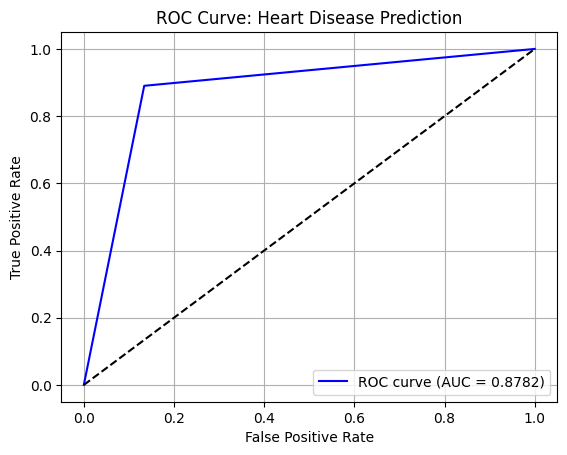

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred2):.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  #diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Heart Disease Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Phân tích Hiệu suất Mô hình Random Forest

### 1. ROC Curve và chỉ số AUC

- **`ROC Curve` (Đường cong ROC):**
    - **Phân tích:** Đường cong màu xanh của Random Forest **nằm rất cao và lệch về phía góc trên bên trái**. Điều này chứng tỏ mô hình có khả năng phân loại rất tốt.

- **`AUC` (Area Under the Curve - Diện tích dưới đường cong):**
    - **Giá trị:** **0.8782**
    - **Kết luận:** Chỉ số AUC này được coi là **xuất sắc**. So với mô hình XGBoost (AUC = 0.8674), mô hình Random Forest cho thấy khả năng **phân biệt giữa hai lớp có phần nhỉnh hơn một chút**.

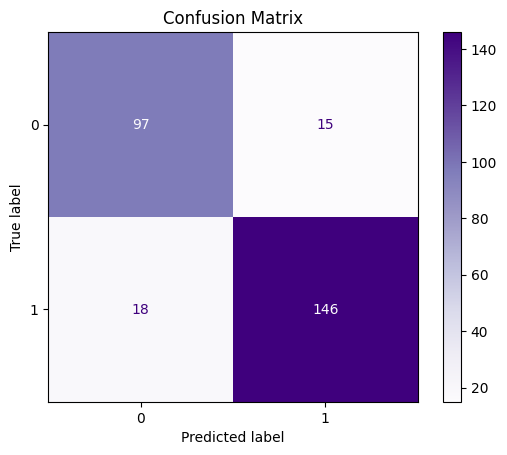

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix")
plt.show()

### 2. Confusion Matrix

- **Giải thích các ô trong Ma trận:**
    - Ma trận này cho thấy chi tiết các dự đoán đúng và sai của mô hình Random Forest.
    - **`True Negative (TN)`: 97**
        - **Ý nghĩa:** Đã dự đoán đúng **97** người là **không có bệnh tim**.
    - **`False Positive (FP)`: 15**
        - **Ý nghĩa:** Đã dự đoán **sai 15** người là có bệnh, trong khi thực tế họ không có.
    - **`False Negative (FN)`: 18**
        - **Ý nghĩa:** Đã dự đoán **sai 18** người là không có bệnh, trong khi thực tế họ có (Bỏ sót).
    - **`True Positive (TP)`: 146**
        - **Ý nghĩa:** Đã dự đoán đúng **146** người là **có bệnh tim**.

- **Đánh giá chi tiết hiệu suất:**
    - **Độ chính xác (Accuracy):**
        - `(146 + 97) / (97 + 15 + 18 + 146) = 243 / 276 ≈ 88.0%`. Độ chính xác này **cao hơn** so với XGBoost (86.6%).
    - **Độ nhạy (Recall/Sensitivity):**
        - `146 / (146 + 18) ≈ 89.0%`. Mô hình tìm ra được **89%** trong tổng số người thật sự có bệnh. Đây là một cải thiện đáng kể so với XGBoost (86.0%).
    - **Cải thiện quan trọng nhất:** Số lượng ca bệnh bị **bỏ sót (False Negatives) đã giảm từ 23 (XGBoost) xuống còn 18**. Đây là một bước tiến rất tích cực trong bài toán y khoa, vì nó giúp giảm thiểu rủi ro cho bệnh nhân.

### 3. Logistic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model3 = LogisticRegression()
model3.fit(X_train_scaled, y_train)
y_pred3 = model3.predict(X_test_scaled)

In [22]:



print(f"Best accuracy: {accuracy_score(y_test, y_pred3):.4f}")
print(f"Best f1 score: {f1_score(y_test, y_pred3):.4f}")
print(f"Best recall score: {recall_score(y_test, y_pred3):.4f}")
print(f"Best roc-auc score: {roc_auc_score(y_test, y_pred3):.4f}")
print(f"Classification report: \n{classification_report(y_test, y_pred3)}")

Best accuracy: 0.8659
Best f1 score: 0.8825
Best recall score: 0.8476
Best roc-auc score: 0.8702
Classification report: 
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       112
           1       0.92      0.85      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276



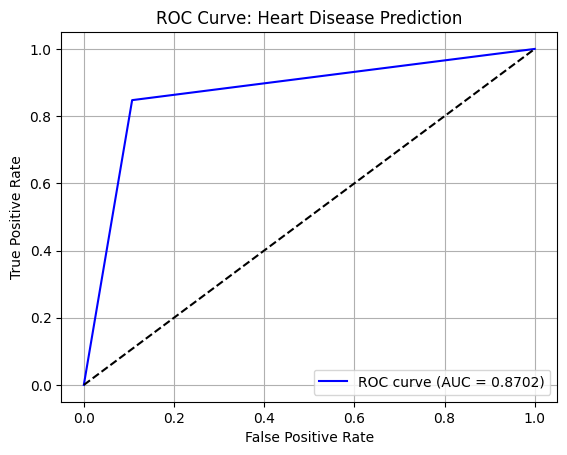

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred3):.4f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Heart Disease Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Phân tích Hiệu suất Mô hình Logistic Regression

### 1. ROC Curve và chỉ số AUC

- **`ROC Curve` (Đường cong ROC):**
    - **Phân tích:** Đường cong ROC của mô hình Logistic Regression cũng cho thấy hiệu suất tốt, nằm cao và lệch về phía góc trên bên trái, chứng tỏ khả năng phân loại tốt hơn nhiều so với việc đoán ngẫu nhiên.

- **`AUC` (Area Under the Curve - Diện tích dưới đường cong):**
    - **Giá trị:** **0.8702**
    - **Kết luận:** Chỉ số AUC này được đánh giá là **tốt**. Nó cao hơn một chút so với XGBoost (0.8674) nhưng lại thấp hơn một chút so với Random Forest (0.8782). Điều này cho thấy cả ba mô hình đều có khả năng phân biệt hai lớp rất cạnh tranh.

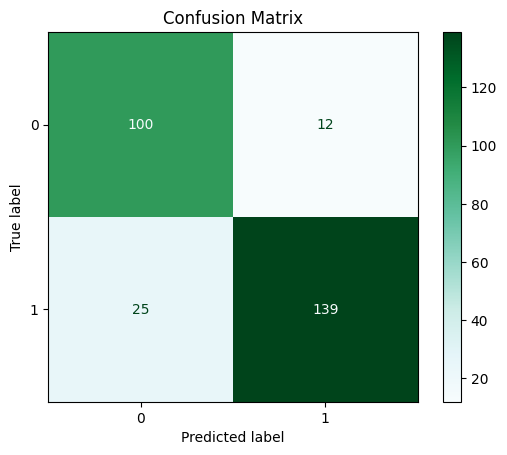

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred3)
disp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
disp.plot(cmap=plt.cm.BuGn)
plt.title("Confusion Matrix")
plt.show()

### 2. Confusion Matrix (Ma trận nhầm lẫn)

- **Giải thích các ô trong Ma trận:**
    - Ma trận này cho thấy chi tiết các dự đoán đúng và sai của mô hình Logistic Regression.
    - **`True Negative (TN)`: 100**
        - **Ý nghĩa:** Đã dự đoán đúng **100** người là **không có bệnh tim**.
    - **`False Positive (FP)`: 12**
        - **Ý nghĩa:** Đã dự đoán **sai 12** người là có bệnh, trong khi thực tế họ không có.
    - **`False Negative (FN)`: 25**
        - **Ý nghĩa:** Đã dự đoán **sai 25** người là không có bệnh, trong khi thực tế họ có (Bỏ sót).
    - **`True Positive (TP)`: 139**
        - **Ý nghĩa:** Đã dự đoán đúng **139** người là **có bệnh tim**.

- **Đánh giá chi tiết hiệu suất:**
    - **Độ chính xác (Accuracy):**
        - `(139 + 100) / (100 + 12 + 25 + 139) = 239 / 276 ≈ 86.6%`. Độ chính xác này **ngang bằng** với XGBoost và thấp hơn một chút so với Random Forest.
    - **Độ nhạy (Recall/Sensitivity):**
        - `139 / (139 + 25) ≈ 84.8%`. Mô hình chỉ tìm ra được khoảng **85%** trong tổng số người thật sự có bệnh. Đây là chỉ số **Recall thấp nhất** trong cả ba mô hình đã xem xét.
    - **Điểm yếu lớn nhất:** Số lượng ca bệnh bị **bỏ sót (False Negatives) là 25**, cao nhất trong cả ba mô hình. Đây là một rủi ro đáng kể trong bối cảnh y tế.
    - **Điểm mạnh:** Mô hình này có số lượng (**False Positives) thấp nhất (chỉ 12)**. Điều này có nghĩa là nó rất "thận trọng" và ít khi chẩn đoán nhầm cho một người khỏe mạnh.


## For the Random Forest and Logistic Regression models, the accuracy was actually reduced after hyperparameter tuning and hence the tuning was removed for them

## A bar plot comparing the performances of each model, concluding that the RandomForest model gave the best results

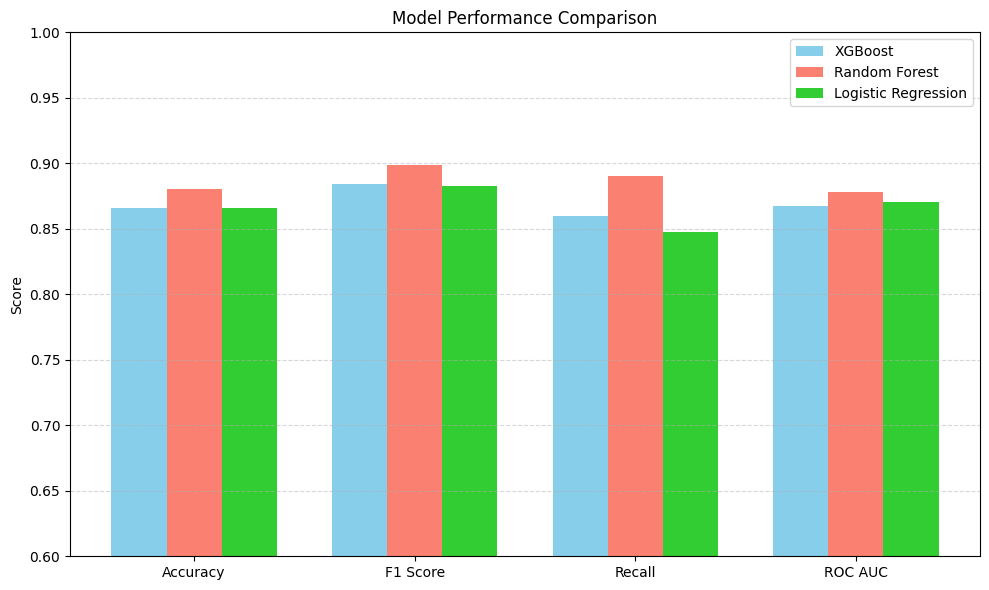

In [25]:

metrics = ['Accuracy', 'F1 Score', 'Recall', 'ROC AUC']

# Scores from each model — plug your real numbers here
model1 = [accuracy_score(y_test, y_pred1), f1_score(y_test, y_pred1), recall_score(y_test, y_pred1), roc_auc_score(y_test, y_pred1)]   # XGBoost
model2 = [accuracy_score(y_test, y_pred2), f1_score(y_test, y_pred2), recall_score(y_test, y_pred2), roc_auc_score(y_test, y_pred2)]   # Random Forest
model3 = [accuracy_score(y_test, y_pred3), f1_score(y_test, y_pred3), recall_score(y_test, y_pred3), roc_auc_score(y_test, y_pred3)]   # Logistic Regression

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, model1, width, label='XGBoost', color='skyblue')
plt.bar(x, model2, width, label='Random Forest', color='salmon')
plt.bar(x + width, model3, width, label='Logistic Regression', color='limegreen')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.ylim(0.6, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Phân tích và Ý nghĩa của Biểu đồ So sánh Hiệu suất Mô hình

Biểu đồ này tổng hợp và so sánh trực quan hiệu suất của ba mô hình bạn đã huấn luyện (XGBoost, Random Forest, và Logistic Regression) dựa trên bốn chỉ số đánh giá quan trọng. Mục tiêu là để xác định mô hình nào hoạt động tốt nhất cho bài toán dự đoán bệnh tim.

### Phân tích chi tiết từng chỉ số

- **`Accuracy` (Độ chính xác):**
    - **Phân tích:** Cả ba mô hình đều đạt độ chính xác rất cao (trên 86%). Mô hình **Random Forest (màu cam)** có cột cao nhất, cho thấy độ chính xác tổng thể nhỉnh hơn một chút so với hai mô hình còn lại.
    - **Ý nghĩa:** Về mặt dự đoán đúng trên toàn bộ dữ liệu, Random Forest đang làm tốt nhất.

- **`F1 Score`:**
    - **Phân tích:** F1 Score là một chỉ số cân bằng giữa Precision (Độ chuẩn xác) và Recall (Độ nhạy). Trên chỉ số này, **Random Forest** một lần nữa cho thấy sự vượt trội rõ rệt với cột điểm cao nhất (khoảng 0.90).
    - **Ý nghĩa:** Điều này cho thấy Random Forest không chỉ chính xác mà còn có sự cân bằng tốt nhất giữa việc không bỏ sót ca bệnh và không chẩn đoán nhầm cho người khỏe mạnh.

- **`Recall` (Độ nhạy):**
    - **Phân tích:** Đây là chỉ số quan trọng bậc nhất trong bài toán y khoa này. Một lần nữa, **Random Forest** có cột **cao nhất một cách rõ ràng** (khoảng 0.89). XGBoost đứng thứ hai, và Logistic Regression có chỉ số Recall thấp nhất.
    - **Ý nghĩa:** `Recall` cao có nghĩa là mô hình **tìm ra được nhiều nhất các trường hợp thực sự có bệnh**, giảm thiểu số ca bị **bỏ sót (False Negatives)**. Việc Random Forest dẫn đầu ở chỉ số này làm cho nó trở thành lựa chọn an toàn và đáng tin cậy nhất.

- **`ROC AUC`:**
    - **Phân tích:** Cả ba mô hình đều có điểm AUC rất cao và cạnh tranh (tất cả đều gần 0.88). Các cột điểm gần như tương đương nhau, cho thấy cả ba đều có khả năng phân biệt rất tốt giữa hai lớp "Có bệnh" và "Không có bệnh".
    - **Ý nghĩa:** Về khả năng phân biệt tổng thể, cả ba mô hình đều là những lựa chọn mạnh mẽ.

### Tổng kết và Lựa chọn Mô hình tốt nhất

Dựa trên sự so sánh toàn diện qua cả bốn chỉ số, chúng ta có thể rút ra kết luận cuối cùng:

- Mặc dù cả ba mô hình đều cho thấy hiệu suất rất tốt, nhưng mô hình **Random Forest là mô hình vượt trội nhất**.
- **Lý do lựa chọn:** Random Forest không chỉ dẫn đầu về `Accuracy` và `F1 Score`, mà quan trọng hơn cả, nó đạt được chỉ số **`Recall` cao nhất**. Trong bối cảnh chẩn đoán bệnh, việc tối đa hóa khả năng phát hiện bệnh nhân (giảm thiểu sai sót bỏ lỡ) là ưu tiên hàng đầu.
- **Kết luận cuối cùng:** Biểu đồ này cung cấp bằng chứng thuyết phục để khẳng định rằng **Random Forest là mô hình phù hợp và hiệu quả nhất** cho bài toán dự đoán bệnh tim này.

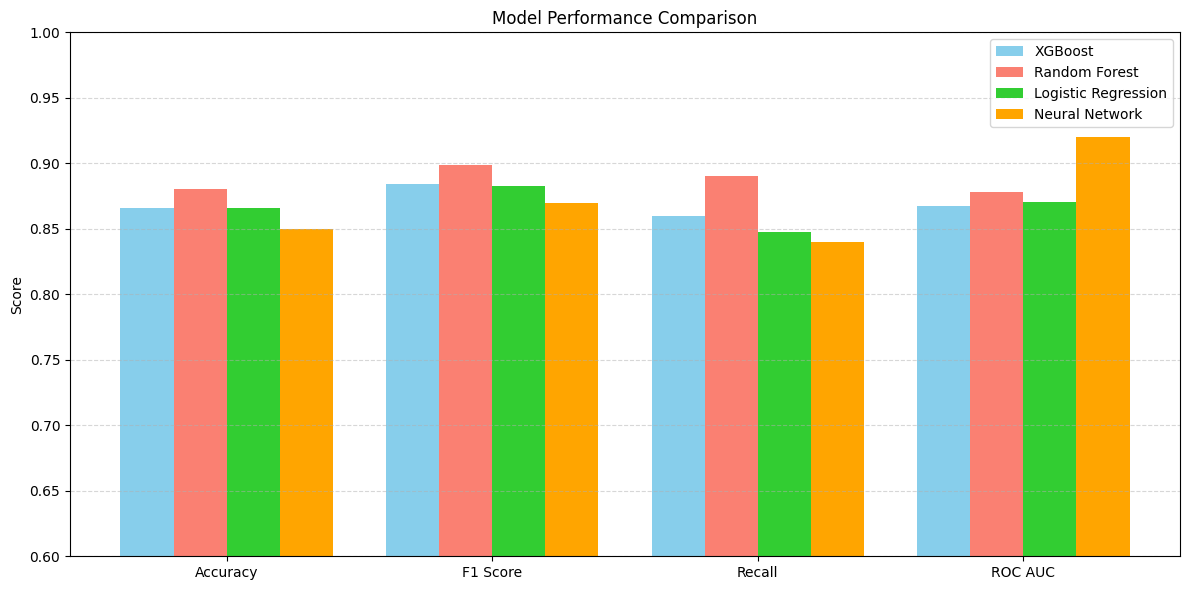

In [27]:
metrics = ['Accuracy', 'F1 Score', 'Recall', 'ROC AUC']

# Các điểm số từ từng mô hình
model1 = [accuracy_score(y_test, y_pred1), f1_score(y_test, y_pred1), recall_score(y_test, y_pred1), roc_auc_score(y_test, y_pred1)]   # XGBoost
model2 = [accuracy_score(y_test, y_pred2), f1_score(y_test, y_pred2), recall_score(y_test, y_pred2), roc_auc_score(y_test, y_pred2)]   # Random Forest
model3 = [accuracy_score(y_test, y_pred3), f1_score(y_test, y_pred3), recall_score(y_test, y_pred3), roc_auc_score(y_test, y_pred3)]   # Logistic Regression
model4 = [0.85, 0.87, 0.84, 0.92]  # Model 14 (giả sử là một mô hình mới)

x = np.arange(len(metrics))
width = 0.2  # Giảm một chút để vừa 4 cột

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, model1, width, label='XGBoost', color='skyblue')
plt.bar(x - 0.5*width, model2, width, label='Random Forest', color='salmon')
plt.bar(x + 0.5*width, model3, width, label='Logistic Regression', color='limegreen')
plt.bar(x + 1.5*width, model4, width, label='Neural Network', color='orange')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.ylim(0.6, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()